When an advertisement clicked by a user, the user has two choices, to buy or not to buy, this is the  Bernoulli trial I want to simulate in this assignment

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from pdb import set_trace

In [15]:
stationary=True
class Bandit():
  def __init__(self, arm_count):
    """
    Multi-armed bandit with rewards 1 or 0.
    
    At initialization, multiple arms are created. The probability of each arm
    returning reward 1 if pulled is sampled from Bernouilli(p), where p randomly
    chosen from Uniform(0,1) at initialization
    """
    self.arm_count = arm_count
    self.generate_thetas()
    self.timestep = 0
    global stationary
    self.stationary=stationary
    
  def generate_thetas(self):
    self.thetas = np.random.uniform(0,1,self.arm_count)
  
  def get_reward_regret(self, arm):
    """ Returns random reward for arm action. Assumes actions are 0-indexed
    Args:
      arm is an int
    """
    self.timestep += 1
    if (self.stationary==False) and (self.timestep%100 == 0) :
      self.generate_thetas()
    # Simulate bernouilli sampling
    sim = np.random.uniform(0,1,self.arm_count)
    rewards = (sim<self.thetas).astype(int)
    reward = rewards[arm]
    regret = self.thetas.max() - self.thetas[arm]
    
    return reward, regret

In [16]:
class BetaAlgo():
  """
  The algos try to learn which Bandit arm is the best to maximize reward.
  
  It does this by modelling the distribution of the Bandit arms with a Beta, 
  assuming the true probability of success of an arm is Bernouilli distributed.
  """
  def __init__(self, bandit):
    """
    Args:
      bandit: the bandit class the algo is trying to model
    """
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.alpha = np.ones(self.arm_count)
    self.beta = np.ones(self.arm_count)
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.alpha[arm] += reward
    self.beta[arm] += 1 - reward

In [17]:
class Thompson(BetaAlgo):
  def __init__(self, bandit):
    super().__init__(bandit)

  @staticmethod
  def name():
    return 'thompson'
  
  def get_action(self):
    """ Bernouilli parameters are sampled from the beta"""
    theta = np.random.normal(self.alpha, self.beta)
    return theta.argmax()

In [41]:
class ThompsonNormal():
    def __init__(self, bandit):
        self.bandit = bandit
        self.user_count = bandit.arm_count
        self.purchased = np.ones(self.user_count)
        self.unpurchased = np.ones(self.user_count)
        self.mu = np.ones(self.user_count)
        self.sigma = np.ones(self.user_count)
  
    def get_reward_regret(self, user):
        reward, regret = self.bandit.get_reward_regret(user)
        self.update_parameters(user, reward)
        return reward, regret
  
    def update_parameters(self, user, reward):
        self.purchased[user] += reward
        self.unpurchased[user] += 1 - reward
        self.mu = self.purchased / (self.purchased + self.unpurchased)
        self.sigma = (self.purchased * self.unpurchased)/((self.purchased + self.unpurchased)**2 * (self.purchased + self.unpurchased +1))

    @staticmethod
    def name():
        return 'thompson normal'
  
    def get_action(self):
        theta = np.random.normal(self.mu, self.sigma)
        return theta.argmax()

In [18]:
epsilon = 0.1
class EpsilonGreedy():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global epsilon
    self.epsilon = epsilon
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) # action count
  
  @staticmethod
  def name():
    return 'epsilon-greedy'
  
  def get_action(self):
    if np.random.uniform(0,1) > self.epsilon:
      action = self.Q.argmax()
    else:
      action = np.random.randint(0, self.arm_count)
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule
 
  

In [19]:
ucb_c = 2
class UCB():
  """
  Epsilon Greedy with incremental update.
  Based on Sutton and Barto pseudo-code, page. 24
  """
  def __init__(self, bandit):
    global ucb_c
    self.ucb_c = ucb_c
    self.bandit = bandit
    self.arm_count = bandit.arm_count
    self.Q = np.zeros(self.arm_count) # q-value of actions
    self.N = np.zeros(self.arm_count) + 0.0001 # action count
    self.timestep = 1
  
  @staticmethod
  def name():
    return 'ucb'
  
  def get_action(self):
    ln_timestep = np.log(np.full(self.arm_count, self.timestep))
    confidence = self.ucb_c * np.sqrt(ln_timestep/self.N)
    action = np.argmax(self.Q + confidence)
    self.timestep += 1
    return action
  
  def get_reward_regret(self, arm):
    reward, regret = self.bandit.get_reward_regret(arm)
    self._update_params(arm, reward)
    return reward, regret
  
  def _update_params(self, arm, reward):
    self.N[arm] += 1 # increment action count
    self.Q[arm] += 1/self.N[arm] * (reward - self.Q[arm]) # inc. update rule

In [20]:
class Random():
    def __init__(self, bandit):
        self.bandit = bandit
        self.arm_count = bandit.arm_count
        
    @staticmethod
    def name():
        return 'random'
    
    def get_action(self):
        theta = np.random.uniform(0,1,self.arm_count)
        return theta.argmax()
    
    def get_reward_regret(self, arm):
        reward, regret = self.bandit.get_reward_regret(arm)
        return reward, regret

In [39]:
def plot_data(y):
  """ y is a 1D vector """
  x = np.arange(y.size)
  _ = plt.plot(x, y, 'o')
  
def multi_plot_data(data, names):
  """ data, names are lists of vectors """
  x = np.arange(data[0].size)
  for i, y in enumerate(data):
    plt.plot(x, y, 'o', markersize=2, label=names[i])
  plt.legend(loc='upper right', prop={'size': 16}, numpoints=10)
  plt.show()
  
def simulate(simulations, timesteps, arm_count, Algorithm):
  """ Simulates the algorithm over 'simulations' epochs """
  sum_regrets = np.zeros(timesteps)
  for e in range(simulations):
    bandit = Bandit(arm_count)
    algo = Algorithm(bandit)
    regrets = np.zeros(timesteps)
    for i in range(timesteps):
      action = algo.get_action()
      reward, regret = algo.get_reward_regret(action)
      regrets[i] = regret
    sum_regrets += regrets  
  mean_regrets = sum_regrets / simulations
  return mean_regrets

def experiment(arm_count, timesteps=1000, simulations=1000):
  """ 
  Standard setup across all experiments 
  Args:
    timesteps: (int) how many steps for the algo to learn the bandit
    simulations: (int) number of epochs
  """

  "algos = [EpsilonGreedy, UCB, Thompson, Random, ThompsonNormal]"
    
  algos = [EpsilonGreedy, UCB, Thompson, Random]
  regrets = []
  names = []
  for algo in algos:
    regrets.append(simulate(simulations, timesteps, arm_count, algo))
    names.append(algo.name())
  multi_plot_data(regrets, names)

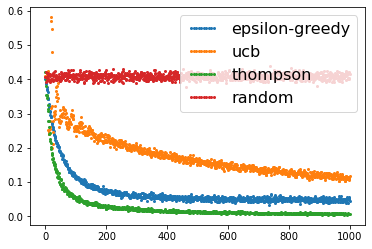

In [40]:
arm_count = 10
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

### Q1<br>Which hyperparameters are important for Thompson Sampling, e-greedy, UBC, and random sampling?

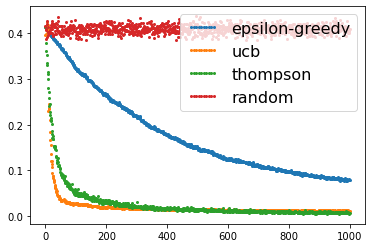

In [24]:
arm_count = 10
epsilon = 0.01
ucb_c = 0.2
stationary=True
experiment(arm_count)

**Thompson :**  **α** and **β** of beta distribution<br> 
    When the α+β is large, the distribution is very narrow, the random number range is small and close to the mean. If this mean is large, this option is obviously very good. For options that have not been tested many times, its α+βare small and the range of random numbers is large, which may generate action which can bring great benefits, this mechanism also a kind of exploration.In this experiment, however, we cannot directly control this two parameters, but we can adjust number of iterations.<br>
**Epsilon-greedy :** **ε**<br> 
    ε controls the balance between exploitation and exploration.<br>
**Ucb : c** <br>
**Random : no superparameter**

### Q2 <br>How does the action space affect Thompson Sampling, e-greedy, UBC, and random sampling?

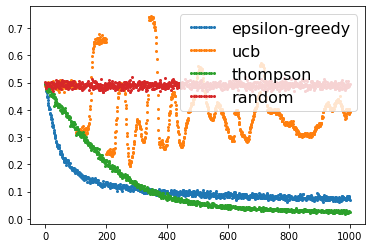

In [27]:
arm_count = 100
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

**a.** Random sampling is least affected by the size of the action space.It's nothing to discuss.<br>
**b.** E-greedy sampling is also less affected by the action space. Because in this experiment, our epsilon is 0.1,It is easier to choose the known best option rather than exploring, as the result , even give it more options, it still chooses more of the good options it found earlier.<br>
**c.** The performance of UCB is very erratic because it requires more attempts in order to evaluate more options.<br>
**d.** Faced a larger action space, Thompson takes more time, but still performs well. 

### Q3 <br>How does stationary affect Thompson Sampling, e-greedy, UBC, and random sampling?

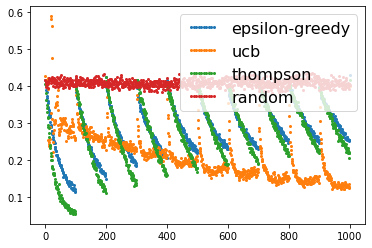

In [29]:
arm_count = 3
epsilon = 0.1
ucb_c = 2
stationary=False
experiment(arm_count)

    Random sampling still not affected by stationary.And facing changing bandit, the ucb which is more willing to explore under our para-meter settings is more quickly to adapt to the changes in the environment and achieve a better result than Thompson and e-greedy.

## Q4<br>When do Thompson Sampling, e-greedy, UBC, and random sampling stop exploring?

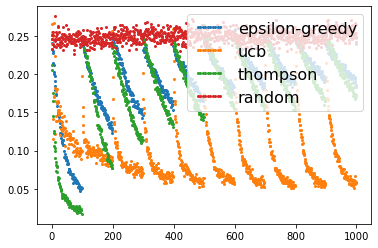

In [30]:
arm_count = 3
epsilon = 0.1
ucb_c = 2
stationary=False
experiment(arm_count)

**Thompson :**  When every alpha + beta is very large, has been selected many times, the random interval of each selection is very small, the exploration will gradually stop.<br>
**Ucb :**  As the confidence interval for each options gets smaller and smaller, the exploration decreases.<br>
**e-greedy :** ε not changed.There is still a small probability to explore, but can not get any important information.<br>
**Random :** exploring everytime

## Q5 <br> How long do Thompson Sampling, e-greedy, UBC, and random sampling remember the past actions

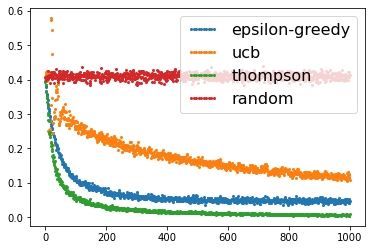

In [32]:
arm_count = 10
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

  All algorithms will remember the results of the action by changing the parameters after making an action, and these changes need about 200 to 300 steps to make a significant impact. After 300 steps, in thompson ,regret achieve 0 , epsilon-greedy also smaller than 0.1, and ucb is about 0.2. It can be said that the past actions have been remembered.<br>
**Random :** remeber nothing

## Q6 <br> Thompson sampling with non-beta distribution (normal)

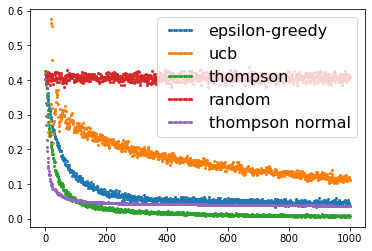

In [38]:
arm_count = 10
epsilon = 0.1
ucb_c = 2
stationary=True
experiment(arm_count)

You can find code at class ThompsonNormal, for getting this result , you need add "ThompsonNormal" in array algos.<br>
And after this experiment, we understand that the beta distribution is better.

## Q7 <br> Did I explain my code clearly?

My code based on following references. I changed some of them to make it more in line with this assignment, rewrote and added some about non-beta thompson and experiment.<br>
**References:** <br>
[1] : https://github.com/andrecianflone/thompson/blob/master/thompson.ipynb <br>
[2] : https://blog.csdn.net/weixin_45662974/article/details/120615735<br>
[3] : http://t.zoukankan.com/gczr-p-11220187.html<br>
[4] : https://lilianweng.github.io/posts/2018-01-23-multi-armed-bandit/

## Q8 <br> Did I explain my licensing clearly?

Copyright <2022> Peichen Han

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.